In [1]:
# Install necessary libraries
!pip install transformers yfinance ccxt pandas matplotlib torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.6/288.6 kB 26.3 MB/s eta 0:00:00
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.11.11
    Uninstalling aiohttp-3.11.11:
      Successfully uninstalled aiohttp-3.11.11


In [2]:
# Import libraries
import yfinance as yf
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import LlamaTokenizer, LlamaForCausalLM
import torch


In [3]:
# Function to fetch stock data using yfinance
def fetch_stock_data(ticker, start_date='2010-01-01', end_date=None):
    stock = yf.Ticker(ticker)
    df = stock.history(start=start_date, end=end_date)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].reset_index()
    df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
    return df

# Function to fetch cryptocurrency data using ccxt
def fetch_crypto_data(symbol='BTC/USD', exchange_name='kraken', timeframe='1d', limit=1000):
    exchange_class = getattr(ccxt, exchange_name)
    exchange = exchange_class()
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
    data = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    return data

# Fetch data for stocks and cryptocurrencies
tesla_data = fetch_stock_data('TSLA', start_date='2020-01-01')
apple_data = fetch_stock_data('AAPL', start_date='2020-01-01')
btc_data = fetch_crypto_data('BTC/USD')
eth_data = fetch_crypto_data('ETH/USD')

# Display sample data
print("Tesla Data:\n", tesla_data.head())
print("Apple Data:\n", apple_data.head())
print("Bitcoin Data:\n", btc_data.head())
print("Ethereum Data:\n", eth_data.head())


Tesla Data:
                   timestamp       open       high        low      close  \
0 2020-01-02 00:00:00-05:00  28.299999  28.713333  28.114000  28.684000   
1 2020-01-03 00:00:00-05:00  29.366667  30.266666  29.128000  29.534000   
2 2020-01-06 00:00:00-05:00  29.364668  30.104000  29.333332  30.102667   
3 2020-01-07 00:00:00-05:00  30.760000  31.441999  30.224001  31.270666   
4 2020-01-08 00:00:00-05:00  31.580000  33.232666  31.215334  32.809334   

      volume  
0  142981500  
1  266677500  
2  151995000  
3  268231500  
4  467164500  
Apple Data:
                   timestamp       open       high        low      close  \
0 2020-01-02 00:00:00-05:00  71.799866  72.856606  71.545380  72.796013   
1 2020-01-03 00:00:00-05:00  72.020454  72.851784  71.862915  72.088318   
2 2020-01-06 00:00:00-05:00  71.206062  72.701485  70.953995  72.662704   
3 2020-01-07 00:00:00-05:00  72.672409  72.929322  72.100418  72.320976   
4 2020-01-08 00:00:00-05:00  72.022843  73.787300  72.0228

In [4]:
# Function to create a text prompt for LLaMA
def create_text_prompt(data, asset_name="Asset", max_entries=5):
    prompt = f"Here is the historical price data for {asset_name}. Predict the next closing price:\n\n"
    data = data.tail(max_entries)
    for _, row in data.iterrows():
        prompt += f"Date: {row['timestamp'].strftime('%Y-%m-%d')}, Open: {row['open']}, High: {row['high']}, Low: {row['low']}, Close: {row['close']}\n"
    prompt += "\nThe next closing price is: "
    return prompt

# Generate prompts for all four assets
tesla_prompt = create_text_prompt(tesla_data, asset_name="Tesla", max_entries=5)
apple_prompt = create_text_prompt(apple_data, asset_name="Apple", max_entries=5)
btc_prompt = create_text_prompt(btc_data, asset_name="Bitcoin", max_entries=5)
eth_prompt = create_text_prompt(eth_data, asset_name="Ethereum", max_entries=5)

# Display prompts
print("Tesla Prompt:\n", tesla_prompt)
print("\nApple Prompt:\n", apple_prompt)
print("\nBitcoin Prompt:\n", btc_prompt)
print("\nEthereum Prompt:\n", eth_prompt)


Tesla Prompt:
 Here is the historical price data for Tesla. Predict the next closing price:

Date: 2025-01-03, Open: 381.4800109863281, High: 411.8800048828125, Low: 379.45001220703125, Close: 410.44000244140625
Date: 2025-01-06, Open: 423.20001220703125, High: 426.42999267578125, Low: 401.70001220703125, Close: 411.04998779296875
Date: 2025-01-07, Open: 405.8299865722656, High: 414.3299865722656, Low: 390.0, Close: 394.3599853515625
Date: 2025-01-08, Open: 392.95001220703125, High: 402.5, Low: 387.3999938964844, Close: 394.94000244140625
Date: 2025-01-10, Open: 391.3999938964844, High: 399.2799987792969, Low: 377.2900085449219, Close: 394.739990234375

The next closing price is: 

Apple Prompt:
 Here is the historical price data for Apple. Predict the next closing price:

Date: 2025-01-03, Open: 243.36000061035156, High: 244.17999267578125, Low: 241.88999938964844, Close: 243.36000061035156
Date: 2025-01-06, Open: 244.30999755859375, High: 247.3300018310547, Low: 243.1999969482422, Cl

In [5]:
# Load LLaMA tokenizer and model
model_name = "huggyllama/llama-7b"  # Adjust based on available model
tokenizer = LlamaTokenizer.from_pretrained(model_name)
model = LlamaForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")

print("LLaMA model loaded successfully.")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.28k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message


config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

LLaMA model loaded successfully.


In [6]:
# Function to generate predictions using LLaMA
def predict_next_price(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to('cuda')  # Move input to GPU
    with torch.no_grad():
        outputs = model.generate(
            inputs.input_ids,
            max_new_tokens=10,
            pad_token_id=tokenizer.eos_token_id
        )
    prediction = tokenizer.decode(outputs[:, inputs.input_ids.shape[-1]:][0], skip_special_tokens=True)
    return prediction

# Predict prices for all four assets
predicted_tesla_price = predict_next_price(tesla_prompt)
predicted_apple_price = predict_next_price(apple_prompt)
predicted_btc_price = predict_next_price(btc_prompt)
predicted_eth_price = predict_next_price(eth_prompt)

# Display predictions
print("Predicted Tesla Price:", predicted_tesla_price)
print("Predicted Apple Price:", predicted_apple_price)
print("Predicted Bitcoin Price:", predicted_btc_price)
print("Predicted Ethereum Price:", predicted_eth_price)


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Predicted Tesla Price: 394.739990
Predicted Apple Price: 236.850006
Predicted Bitcoin Price: 93875.9

Answer
Predicted Ethereum Price: 3234.97

Answer


In [7]:
# Function to generate predictions for multiple days
def generate_predictions_for_days(data, num_days=5, asset_name="Asset"):
    future_data = data.copy()
    predictions = []

    for i in range(num_days):
        prompt = create_text_prompt(future_data, asset_name=asset_name, max_entries=5)
        predicted_price = predict_next_price(prompt)
        predicted_price_value = float(predicted_price.split()[0])
        predictions.append(predicted_price_value)

        # Add the predicted price to the dataset for the next iteration
        next_date = future_data['timestamp'].iloc[-1] + pd.DateOffset(1)
        new_row = pd.DataFrame({
            'timestamp': [next_date],
            'open': [np.nan],
            'high': [np.nan],
            'low': [np.nan],
            'close': [predicted_price_value],
            'volume': [np.nan]
        })

        future_data = pd.concat([future_data, new_row], ignore_index=True)

    return predictions

# Generate predictions for all four assets
tesla_predictions = generate_predictions_for_days(tesla_data, num_days=5, asset_name="Tesla")
apple_predictions = generate_predictions_for_days(apple_data, num_days=5, asset_name="Apple")
btc_predictions = generate_predictions_for_days(btc_data, num_days=5, asset_name="Bitcoin")
eth_predictions = generate_predictions_for_days(eth_data, num_days=5, asset_name="Ethereum")

# Display predictions
print("Predicted Tesla Prices for Next 5 Days:", tesla_predictions)
print("Predicted Apple Prices for Next 5 Days:", apple_predictions)
print("Predicted Bitcoin Prices for Next 5 Days:", btc_predictions)
print("Predicted Ethereum Prices for Next 5 Days:", eth_predictions)


Predicted Tesla Prices for Next 5 Days: [394.73999, 394.73999, 394.73999, 394.73999, 394.73999]
Predicted Apple Prices for Next 5 Days: [236.850006, 236.850006, 236.850006, 236.850006, 236.850006]
Predicted Bitcoin Prices for Next 5 Days: [93875.9, 93875.9, 93875.9, 93875.9, 93875.9]
Predicted Ethereum Prices for Next 5 Days: [3234.97, 3234.97, 3234.97, 3234.97, 3234.97]


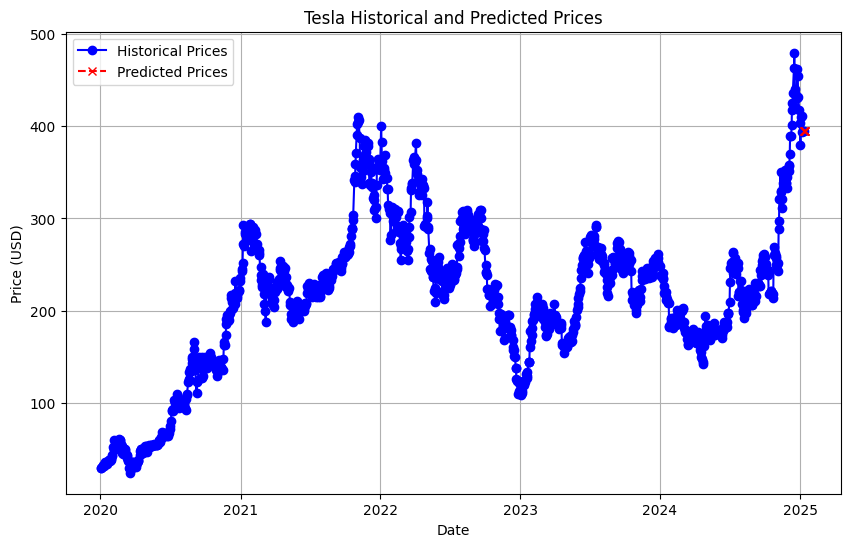

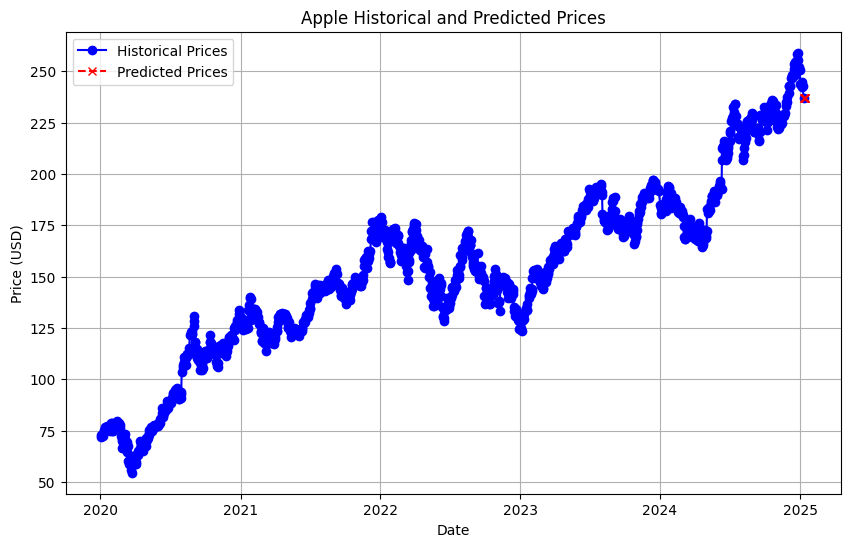

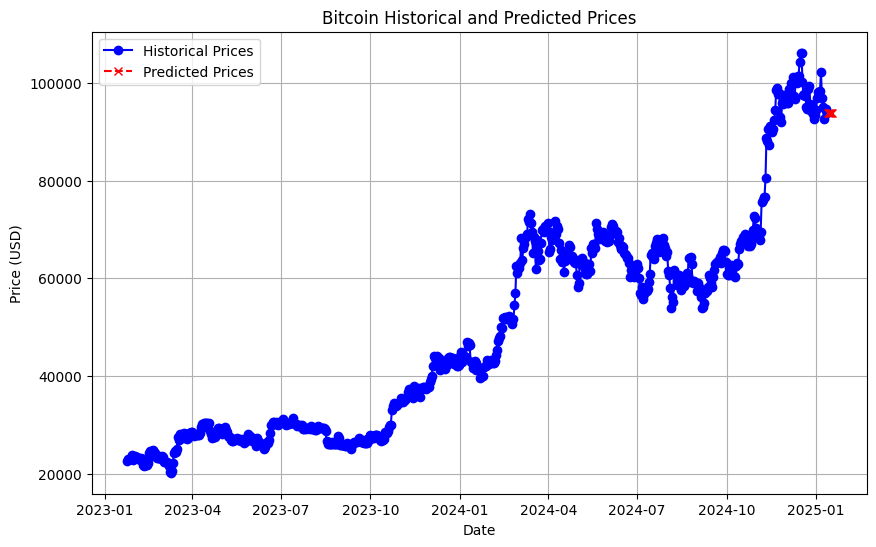

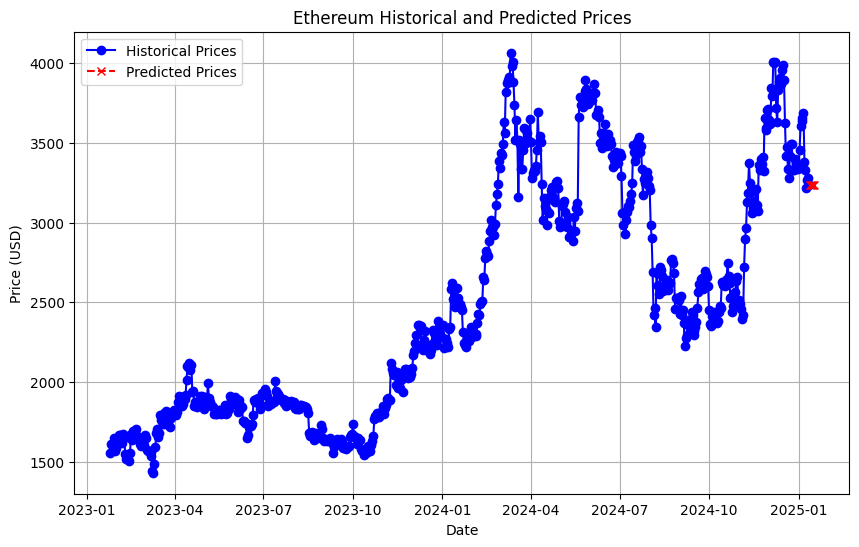

In [8]:
# Function to plot predictions along with historical data
def plot_predictions(data, predicted_prices, asset_name="Asset", num_days=5):
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    plt.figure(figsize=(10, 6))

    # Plot historical closing prices
    plt.plot(data['timestamp'], data['close'], label='Historical Prices', marker='o', color='blue')

    # Generate future dates
    last_date = data['timestamp'].iloc[-1]
    future_dates = [last_date + pd.DateOffset(days=i+1) for i in range(num_days)]

    # Plot predicted prices
    plt.plot(future_dates, predicted_prices, label='Predicted Prices', marker='x', color='red', linestyle='--')

    plt.title(f"{asset_name} Historical and Predicted Prices")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot predictions for all four assets
plot_predictions(tesla_data, tesla_predictions, asset_name="Tesla", num_days=5)
plot_predictions(apple_data, apple_predictions, asset_name="Apple", num_days=5)
plot_predictions(btc_data, btc_predictions, asset_name="Bitcoin", num_days=5)
plot_predictions(eth_data, eth_predictions, asset_name="Ethereum", num_days=5)


In [9]:
# Function to compute evaluation metrics
def compute_metrics(actual, predicted):
    mse = np.mean((np.array(actual) - np.array(predicted)) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(np.array(actual) - np.array(predicted)))
    return mse, rmse, mae


In [10]:
# Predict prices for Tesla
predicted_tesla_price = predict_next_price(tesla_prompt)

# Create a list of identical predictions (as per the original behavior)
predicted_tesla_prices = [float(predicted_tesla_price.split()[0])] * 5

# Compute evaluation metrics for Tesla
actual_tesla_prices = tesla_data['close'].tail(5).tolist()
tesla_mse, tesla_rmse, tesla_mae = compute_metrics(actual_tesla_prices, predicted_tesla_prices)

# Display Tesla metrics
print(f"Tesla - MSE: {tesla_mse}, RMSE: {tesla_rmse}, MAE: {tesla_mae}")


Tesla - MSE: 102.53816543530188, RMSE: 10.126113046737226, MAE: 6.518005511718764


In [11]:
# Predict prices for Apple
predicted_apple_price = predict_next_price(apple_prompt)

# Create a list of identical predictions
predicted_apple_prices = [float(predicted_apple_price.split()[0])] * 5

# Compute evaluation metrics for Apple
actual_apple_prices = apple_data['close'].tail(5).tolist()
apple_mse, apple_rmse, apple_mae = compute_metrics(actual_apple_prices, predicted_apple_prices)

# Display Apple metrics
print(f"Apple - MSE: {apple_mse}, RMSE: {apple_rmse}, MAE: {apple_mae}")


Apple - MSE: 34.35088675480286, RMSE: 5.860962954566669, MAE: 5.173996075195305


In [12]:
# Predict prices for Bitcoin
predicted_btc_price = predict_next_price(btc_prompt)

# Create a list of identical predictions
predicted_btc_prices = [float(predicted_btc_price.split()[0])] * 5

# Compute evaluation metrics for Bitcoin
actual_btc_prices = btc_data['close'].tail(5).tolist()
btc_mse, btc_rmse, btc_mae = compute_metrics(actual_btc_prices, predicted_btc_prices)

# Display Bitcoin metrics
print(f"Bitcoin - MSE: {btc_mse}, RMSE: {btc_rmse}, MAE: {btc_mae}")


Bitcoin - MSE: 871589.7480000046, RMSE: 933.5897107402184, MAE: 807.5600000000035


In [13]:
# Predict prices for Ethereum
predicted_eth_price = predict_next_price(eth_prompt)

# Create a list of identical predictions
predicted_eth_prices = [float(predicted_eth_price.split()[0])] * 5

# Compute evaluation metrics for Ethereum
actual_eth_prices = eth_data['close'].tail(5).tolist()
eth_mse, eth_rmse, eth_mae = compute_metrics(actual_eth_prices, predicted_eth_prices)

# Display Ethereum metrics
print(f"Ethereum - MSE: {eth_mse}, RMSE: {eth_rmse}, MAE: {eth_mae}")


Ethereum - MSE: 2362.046140000023, RMSE: 48.60088620591216, MAE: 37.146000000000186
